In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import pysm3
import pysm3.units as u
from astropy import units as u
import pysm3.units as u
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation,  get_instrument
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline


In [68]:
nside = 64
instrument = get_instrument('LiteBIRD')

freq_mapsQ = get_observation(instrument, 'd0s0',nside=nside)[:,1,:]
freq_mapsU = get_observation(instrument, 'd0s0',nside=nside)[:,2,:]
freq_maps = get_observation(instrument, 'd0s0',nside=nside)

freq_mapsP = np.sqrt(np.power(freq_mapsQ,2)+np.power(freq_mapsU,2))


In [69]:
components= [CMB(),Dust(50.),Synchrotron(50.)]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)


In [70]:
invN=np.eye(15)
invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
invNd_P = np.einsum('ij,jp->ip', invN, freq_mapsP)



In [71]:
def spectral_likelihood(x):
    A_maxL = A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    print(x, logL)
    if logL != logL:
        return 0.0
    return -logL

[ 1.2 20.  -3. ] 27509042105264.453
[ 1.20707071 20.         -3.        ] 27509549104559.926
[ 1.21414141 20.         -3.        ] 27510045466961.582
[ 1.22121212 20.         -3.        ] 27510531178917.2
[ 1.22828283 20.         -3.        ] 27511006227874.91
[ 1.23535354 20.         -3.        ] 27511470602265.023
[ 1.24242424 20.         -3.        ] 27511924291486.508
[ 1.24949495 20.         -3.        ] 27512367285891.363
[ 1.25656566 20.         -3.        ] 27512799576769.582
[ 1.26363636 20.         -3.        ] 27513221156334.973
[ 1.27070707 20.         -3.        ] 27513632017709.54
[ 1.27777778 20.         -3.        ] 27514032154910.223
[ 1.28484848 20.         -3.        ] 27514421562833.637
[ 1.29191919 20.         -3.        ] 27514800237242.22
[ 1.2989899 20.        -3.       ] 27515168174750.8
[ 1.30606061 20.         -3.        ] 27515525372812.38
[ 1.31313131 20.         -3.        ] 27515871829703.68
[ 1.32020202 20.         -3.        ] 27516207544513.402
[ 1.327

Text(0, 0.5, 'Likelihood value')

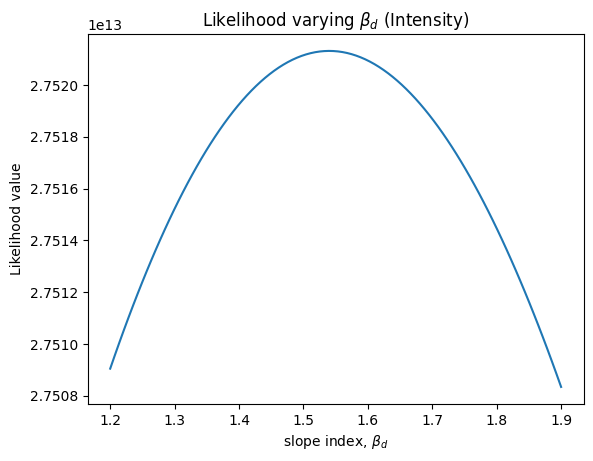

In [72]:
Betad = np.linspace(1.2,1.9,100)
result= []
for i in Betad:
    result.append(spectral_likelihood(np.array([i,20,-3])))

plt.plot(Betad,np.abs(result))
plt.title(r'Likelihood varying $\beta_d$ (Intensity)')
plt.xlabel(r'slope index, $\beta_d$')
plt.ylabel('Likelihood value')


In [73]:
''' Betad = np.linspace(1.2,1.9,100)
Betas = np.linspace(-2,-4,100)
result = []
for i in Betad:
    for j in Betas:
        result.append(spectral_likelihood(np.array([i,20,j])))
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Betad, Betas, np.abs(result))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
'''

" Betad = np.linspace(1.2,1.9,100)\nBetas = np.linspace(-2,-4,100)\nresult = []\nfor i in Betad:\n    for j in Betas:\n        result.append(spectral_likelihood(np.array([i,20,j])))\n \nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.plot_surface(Betad, Betas, np.abs(result))\n\nax.set_xlabel('X Label')\nax.set_ylabel('Y Label')\nax.set_zlabel('Z Label')\n\nplt.show()\n"

[ 1.54 18.   -3.  ] 27520866166694.848
[ 1.54       18.04545455 -3.        ] 27520888886368.3
[ 1.54       18.09090909 -3.        ] 27520910887299.277
[ 1.54       18.13636364 -3.        ] 27520932180966.934
[ 1.54       18.18181818 -3.        ] 27520952778657.82
[ 1.54       18.22727273 -3.        ] 27520972691469.453
[ 1.54       18.27272727 -3.        ] 27520991930312.72
[ 1.54       18.31818182 -3.        ] 27521010505917.145
[ 1.54       18.36363636 -3.        ] 27521028428833.117
[ 1.54       18.40909091 -3.        ] 27521045709435.227
[ 1.54       18.45454545 -3.        ] 27521062357925.95
[ 1.54 18.5  -3.  ] 27521078384338.812
[ 1.54       18.54545455 -3.        ] 27521093798541.047
[ 1.54       18.59090909 -3.        ] 27521108610237.34
[ 1.54       18.63636364 -3.        ] 27521122828972.277
[ 1.54       18.68181818 -3.        ] 27521136464133.477
[ 1.54       18.72727273 -3.        ] 27521149524954.543
[ 1.54       18.77272727 -3.        ] 27521162020517.32
[ 1.54       18.8

Text(0, 0.5, 'Likelihood value')

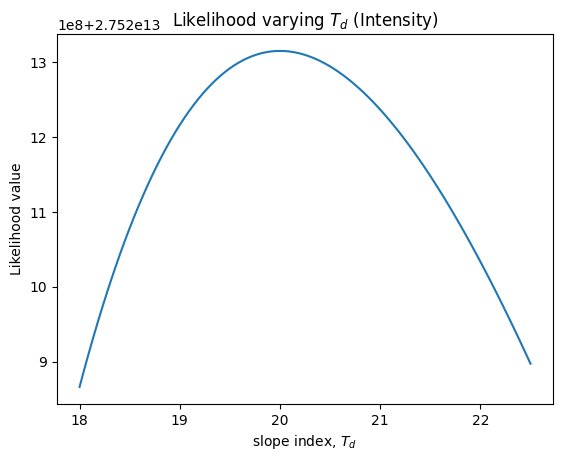

In [74]:
T = np.linspace(18,22.5,100)
result= []
for i in T:
    result.append(spectral_likelihood(np.array([1.54,i,-3])))

plt.plot(T,np.abs(result))
plt.title(r'Likelihood varying $T_d$ (Intensity)')
plt.xlabel(r'slope index, $T_d$')
plt.ylabel('Likelihood value')

[ 1.54 20.   -2.  ] 27521312377815.895
[ 1.54       20.         -2.02020202] 27521312486037.43
[ 1.54       20.         -2.04040404] 27521312592834.25
[ 1.54       20.         -2.06060606] 27521312698124.34
[ 1.54       20.         -2.08080808] 27521312801829.14
[ 1.54      20.        -2.1010101] 27521312903874.7
[ 1.54       20.         -2.12121212] 27521313004190.19
[ 1.54       20.         -2.14141414] 27521313102709.105
[ 1.54       20.         -2.16161616] 27521313199368.652
[ 1.54       20.         -2.18181818] 27521313294109.832
[ 1.54      20.        -2.2020202] 27521313386877.016
[ 1.54       20.         -2.22222222] 27521313477618.62
[ 1.54       20.         -2.24242424] 27521313566286.16
[ 1.54       20.         -2.26262626] 27521313652835.066
[ 1.54       20.         -2.28282828] 27521313737223.64
[ 1.54      20.        -2.3030303] 27521313819413.89
[ 1.54       20.         -2.32323232] 27521313899370.53
[ 1.54       20.         -2.34343434] 27521313977061.844
[ 1.54       

Text(0, 0.5, 'Likelihood value')

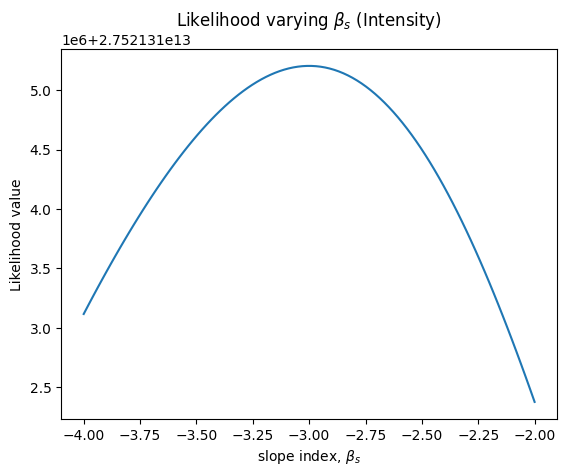

In [75]:
Betas = np.linspace(-2,-4,100)
result= []
for i in Betas:
    result.append(spectral_likelihood(np.array([1.54,20,i])))

plt.plot(Betas,np.abs(result))
plt.title(r'Likelihood varying $\beta_s$ (Intensity)')
plt.xlabel(r'slope index, $\beta_s$')
plt.ylabel('Likelihood value')


In [76]:
x0 = np.array([1.54,20,-3])
max= minimize(spectral_likelihood,x0)
max.x

[ 1.54 20.   -3.  ] 27521315204038.234
[ 1.54000001 20.         -3.        ] 27521315204038.133
[ 1.54       20.00000001 -3.        ] 27521315204038.164
[ 1.54       20.         -2.99999999] 27521315204038.117
[ 0.93755428 19.5829222  -3.69512967] 27478704312530.54
[ 0.9375543  19.5829222  -3.69512967] 27478704314558.29
[ 0.93755428 19.58292221 -3.69512967] 27478704312597.234
[ 0.93755428 19.5829222  -3.69512966] 27478704312577.01
[ 1.53991768 19.99994301 -3.00009499] 27521315203305.12
[ 1.53991769 19.99994301 -3.00009499] 27521315203305.457
[ 1.53991768 19.99994302 -3.00009499] 27521315203305.26
[ 1.53991768 19.99994301 -3.00009497] 27521315203305.184
[ 1.53997339 19.99998158 -3.0000307 ] 27521315203962.805
[ 1.5399734  19.99998158 -3.0000307 ] 27521315203962.918
[ 1.53997339 19.99998159 -3.0000307 ] 27521315203962.78
[ 1.53997339 19.99998158 -3.00003069] 27521315203962.7
[ 1.5399934  19.99999543 -3.00000762] 27521315204033.836
[ 1.53999342 19.99999543 -3.00000762] 27521315204033.875


array([ 1.53999915, 19.99999941, -3.00000098])

In [77]:
def spectral_likelihoodP(x):
    A_maxL = A_ev(x) 
    logL = 0
    AtNd= np.einsum('ji,jp->ip', A_maxL, invNd_P)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('ip,ij,jp->', AtNd, AtNA, AtNd)
    print(x, logL)
    if logL != logL:
        return 0.0
    return -logL



[ 1.2 20.  -3. ] 12742628632.887732
[ 1.20707071 20.         -3.        ] 12742860486.324207
[ 1.21414141 20.         -3.        ] 12743087417.554579
[ 1.22121212 20.         -3.        ] 12743309420.39564
[ 1.22828283 20.         -3.        ] 12743526489.125372
[ 1.23535354 20.         -3.        ] 12743738618.4753
[ 1.24242424 20.         -3.        ] 12743945803.623737
[ 1.24949495 20.         -3.        ] 12744148040.18906
[ 1.25656566 20.         -3.        ] 12744345324.221891
[ 1.26363636 20.         -3.        ] 12744537652.199728
[ 1.27070707 20.         -3.        ] 12744725021.018599
[ 1.27777778 20.         -3.        ] 12744907427.98779
[ 1.28484848 20.         -3.        ] 12745084870.822369
[ 1.29191919 20.         -3.        ] 12745257347.636984
[ 1.2989899 20.        -3.       ] 12745424856.9395
[ 1.30606061 20.         -3.        ] 12745587397.624321
[ 1.31313131 20.         -3.        ] 12745744968.966393
[ 1.32020202 20.         -3.        ] 12745897570.614698
[ 1.3

Text(0, 0.5, 'Likelihood value')

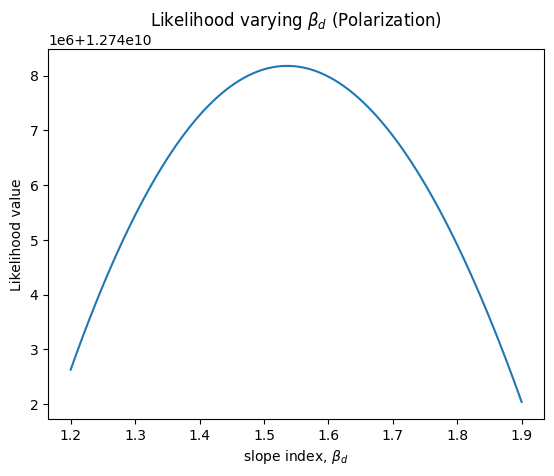

In [78]:
Betad = np.linspace(1.2,1.9,100)
result= []
for i in Betad:
    x0=np.array([i,20,-3])
    result.append(spectral_likelihoodP(x0))

plt.plot(Betad,np.abs(result))
plt.title(r'Likelihood varying $\beta_d$ (Polarization)')
plt.xlabel(r'slope index, $\beta_d$')
plt.ylabel('Likelihood value')



[ 1.54 18.   -3.  ] 12747991566.705717
[ 1.54       18.04040404 -3.        ] 12748000409.04802
[ 1.54       18.08080808 -3.        ] 12748008990.885239
[ 1.54       18.12121212 -3.        ] 12748017315.93703
[ 1.54       18.16161616 -3.        ] 12748025387.867598
[ 1.54      18.2020202 -3.       ] 12748033210.285988
[ 1.54       18.24242424 -3.        ] 12748040786.747751
[ 1.54       18.28282828 -3.        ] 12748048120.75516
[ 1.54       18.32323232 -3.        ] 12748055215.758484
[ 1.54       18.36363636 -3.        ] 12748062075.156654
[ 1.54      18.4040404 -3.       ] 12748068702.298317
[ 1.54       18.44444444 -3.        ] 12748075100.482557
[ 1.54       18.48484848 -3.        ] 12748081272.959435
[ 1.54       18.52525253 -3.        ] 12748087222.93155
[ 1.54       18.56565657 -3.        ] 12748092953.553852
[ 1.54       18.60606061 -3.        ] 12748098467.935349
[ 1.54       18.64646465 -3.        ] 12748103769.138927
[ 1.54       18.68686869 -3.        ] 12748108860.183006
[ 

Text(0, 0.5, 'Likelihood value')

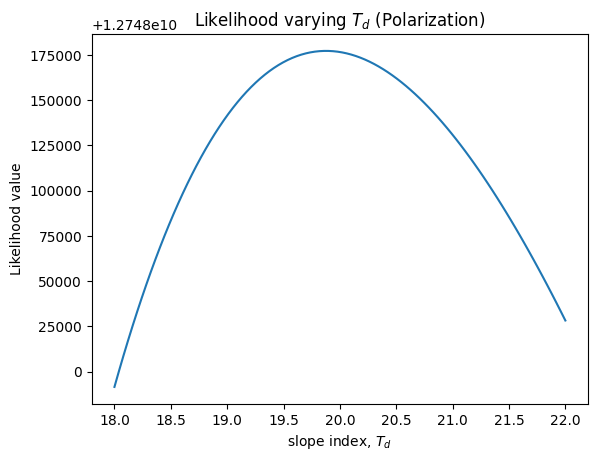

In [79]:
T = np.linspace(18,22,100)
result= []
for i in T:
    x0=np.array([1.54,i,-3])
    result.append(spectral_likelihoodP(x0))

plt.plot(T,np.abs(result))
plt.title(r'Likelihood varying $T_d$ (Polarization)')
plt.xlabel(r'slope index, $T_d$')
plt.ylabel('Likelihood value')

[ 1.54 20.   -2.  ] 12748071475.191439
[ 1.54       20.         -2.02525253] 12748075915.40701
[ 1.54       20.         -2.05050505] 12748080298.177567
[ 1.54       20.         -2.07575758] 12748084618.387093
[ 1.54      20.        -2.1010101] 12748088871.221123
[ 1.54       20.         -2.12626263] 12748093052.163233
[ 1.54       20.         -2.15151515] 12748097156.99038
[ 1.54       20.         -2.17676768] 12748101181.767817
[ 1.54      20.        -2.2020202] 12748105122.841568
[ 1.54       20.         -2.22727273] 12748108976.832174
[ 1.54       20.         -2.25252525] 12748112740.625887
[ 1.54       20.         -2.27777778] 12748116411.367563
[ 1.54      20.        -2.3030303] 12748119986.451445
[ 1.54       20.         -2.32828283] 12748123463.512777
[ 1.54       20.         -2.35353535] 12748126840.41888
[ 1.54       20.         -2.37878788] 12748130115.260727
[ 1.54      20.        -2.4040404] 12748133286.343563
[ 1.54       20.         -2.42929293] 12748136352.178381
[ 1.54 

Text(0, 0.5, 'Likelihood value')

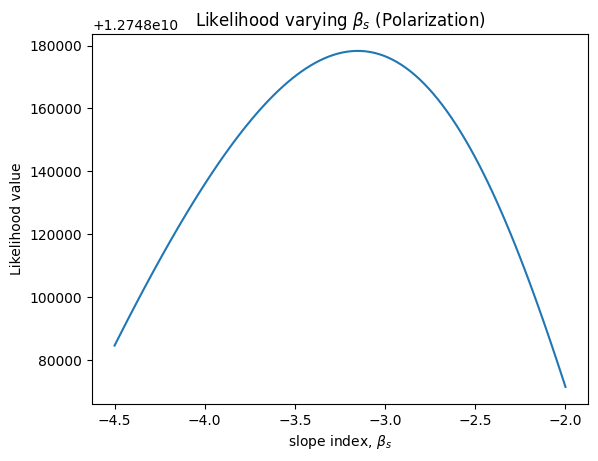

In [80]:
Betas = np.linspace(-2,-4.5,100)
result= []
for i in Betas:
    x0=np.array([1.54,20,i])
    result.append(spectral_likelihoodP(x0))

plt.plot(Betas,np.abs(result))
plt.title(r'Likelihood varying $\beta_s$ (Polarization)')
plt.xlabel(r'slope index, $\beta_s$')
plt.ylabel('Likelihood value')

In [81]:
x0 = np.array([1.54,20,-3])
max= minimize(spectral_likelihoodP,x0)
max.x


[ 1.54 20.   -3.  ] 12748176585.85559
[ 1.54000001 20.         -3.        ] 12748176585.849901
[ 1.54       20.00000001 -3.        ] 12748176585.855415
[ 1.54       20.         -2.99999999] 12748176585.855244
[ 0.53235198 19.96892269 -3.06147903] 12701203927.85339
[ 0.532352   19.96892269 -3.06147903] 12701203929.068554
[ 0.53235198 19.9689227  -3.06147903] 12701203927.898205
[ 0.53235198 19.96892269 -3.06147901] 12701203927.939692
[ 1.53669984 19.99989822 -3.00020135] 12748177316.450985
[ 1.53669985 19.99989822 -3.00020135] 12748177316.450008
[ 1.53669984 19.99989823 -3.00020135] 12748177316.450903
[ 1.53669984 19.99989822 -3.00020134] 12748177316.450727
[ 1.53878536 19.97734333 -3.08633198] 12748178266.756836
[ 1.53878537 19.97734333 -3.08633198] 12748178266.755768
[ 1.53878536 19.97734335 -3.08633198] 12748178266.756723
[ 1.53878536 19.97734333 -3.08633196] 12748178266.756716
[ 1.54485463 19.72185599 -3.13906297] 12748178184.22746
[ 1.54485464 19.72185599 -3.13906297] 12748178184.22

array([ 1.54328503, 19.83057854, -3.13602678])

In [82]:
instr = np.load('instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instr_standardize = standardize_instrument(instr_)

#print(instr_standardize)
print(instr)




{'LB_LFT_40': {'freq': 40.0, 'freq_band': 12.0, 'beam': 70.5, 'P_sens': 37.42}, 'LB_LFT_50': {'freq': 50.0, 'freq_band': 15.0, 'beam': 58.5, 'P_sens': 33.46}, 'LB_LFT_60': {'freq': 60.0, 'freq_band': 14.0, 'beam': 51.1, 'P_sens': 21.31}, 'LB_LFT_68a': {'freq': 68.0, 'freq_band': 16.0, 'beam': 41.6, 'P_sens': 19.91}, 'LB_LFT_68b': {'freq': 68.0, 'freq_band': 16.0, 'beam': 47.1, 'P_sens': 31.76}, 'LB_LFT_78a': {'freq': 78.0, 'freq_band': 18.0, 'beam': 36.9, 'P_sens': 15.56}, 'LB_LFT_78b': {'freq': 78.0, 'freq_band': 18.0, 'beam': 43.8, 'P_sens': 19.14}, 'LB_LFT_89a': {'freq': 89.0, 'freq_band': 20.0, 'beam': 33.0, 'P_sens': 12.28}, 'LB_LFT_89b': {'freq': 89.0, 'freq_band': 20.0, 'beam': 41.5, 'P_sens': 28.77}, 'LB_LFT_100': {'freq': 100.0, 'freq_band': 23.0, 'beam': 30.2, 'P_sens': 10.34}, 'LB_LFT_119': {'freq': 119.0, 'freq_band': 36.0, 'beam': 26.3, 'P_sens': 7.69}, 'LB_LFT_140': {'freq': 140.0, 'freq_band': 42.0, 'beam': 23.7, 'P_sens': 7.24}, 'LB_MFT_100': {'freq': 100.0, 'freq_band'